# Mexico FHR Feature Engineering Notebook
This notebook analyzes the Fine Hotels + Resorts (FHR) data (Nov 2025 – Oct 2026) to uncover explainable features for our proprietary value metric.


## Program Benefit Reference
**Fine Hotels + Resorts (FHR)**
- 12pm check-in when available
- Room upgrade upon arrival when available (some categories excluded)
- Daily breakfast for two
- Property credit: $100 default but can surface as $200/$300+ depending on the property
- Complimentary Wi-Fi
- Guaranteed 4pm late check-out

**The Hotel Collection (THC)** (for upcoming comparative analysis)
- 12pm check-in when available
- Room upgrade upon arrival when available
- Property credit: $100+
- Late check-out when available

We will develop features that capture how much of this value shows up in AMEX’s data feed, starting with FHR, then mirror the approach for THC.


In [189]:
from __future__ import annotations

import json
import math
import re
import sqlite3
from collections import Counter, defaultdict
from pathlib import Path
from typing import Any

try:
    import pandas as pd
except ImportError:
    pd = None
    print('Install pandas for richer tables: pip install pandas')

NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent
DB_PATH = ROOT / 'data' / 'storage' / 'hotels.sqlite3'
assert DB_PATH.exists(), f"Missing database at {DB_PATH}"
DB_PATH


PosixPath('/home/timstafford/PyCharmMiscProject/data/storage/hotels.sqlite3')

## Schema & Table Inventory


In [188]:
with sqlite3.connect(DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name").fetchall()
    table_counts = []
    for row in tables:
        name = row['name']
        if name.startswith('sqlite_'):
            continue
        count = conn.execute(f"SELECT COUNT(*) FROM {name}").fetchone()[0]
        table_counts.append({'table': name, 'row_count': count})

if pd:
    display(pd.DataFrame(table_counts))
else:
    table_counts


,table,row_count
0,destinations,172
1,hotel_features,311819
2,hotel_payloads,248934
3,hotel_program_benefits,15169
4,hotel_promotions,1095
5,hotels,2807
6,meta,1
7,rate_components,2127105
8,rate_nightly_prices,1247346
9,rate_snapshots,420934


In [190]:
TABLES = ['search_runs', 'rate_snapshots', 'hotels', 'hotel_promotions', 'rate_components', 'rate_nightly_prices']
column_rows = []
with sqlite3.connect(DB_PATH) as conn:
    for table in TABLES:
        try:
            cols = conn.execute(f"PRAGMA table_info({table})").fetchall()
        except sqlite3.OperationalError:
            continue
        for cid, name, col_type, notnull, dflt_value, pk in cols:
            column_rows.append({
                'table': table,
                'column': name,
                'type': col_type,
                'required': bool(notnull),
                'primary_key': bool(pk),
            })

if pd:
    column_df = pd.DataFrame(column_rows)
    display(column_df.head(80))
    print(f"... {len(column_rows)} total columns. Filter column_df[column_df['table']=='rate_snapshots'] for the full rate schema.")
else:
    column_rows[:50]


,table,column,type,required,primary_key
0,search_runs,id,INTEGER,False,True
1,search_runs,destination_key,TEXT,True,False
2,search_runs,destination_group,TEXT,False,False
3,search_runs,destination_name,TEXT,False,False
4,search_runs,label,TEXT,False,False
...,...,...,...,...,...
75,hotels,user_rating,REAL,False,False
76,hotels,user_rating_count,INTEGER,False,False
77,hotels,hero_image,TEXT,False,False
78,hotels,marketing_insider_tip,TEXT,False,False


... 121 total columns. Filter column_df[column_df['table']=='rate_snapshots'] for the full rate schema.


## Load FHR Mexico Rates (Nov 2025 – Oct 2026)


In [191]:
FHR_QUERY = '''
SELECT
    rs.run_id,
    sr.destination_name,
    sr.destination_group,
    sr.check_in,
    sr.check_out,
    sr.nights,
    rs.hotel_collection,
    rs.property_id,
    h.name AS hotel_name,
    COALESCE(h.brand_name, h.chain_name) AS brand_name,
    h.user_rating,
    h.user_rating_count,
    h.address_state,
    rs.average_nightly_rate,
    rs.pricing_total_inclusive,
    rs.pricing_total,
    rs.pricing_base,
    rs.special_offer_json,
    rs.supplier_rate_promotion_json,
    rs.is_breakfast_included,
    rs.is_food_beverage_credit,
    rs.is_free_cancellation,
    rs.is_parking_included,
    rs.is_shuttle_included
FROM rate_snapshots rs
JOIN search_runs sr ON sr.id = rs.run_id
LEFT JOIN hotels h ON h.property_id = rs.property_id
WHERE sr.destination_group = 'Mexico'
  AND rs.hotel_collection = 'FHR'
  AND sr.check_in BETWEEN '2025-11-01' AND '2026-10-31'
'''

with sqlite3.connect(DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    fhr_rows = [dict(row) for row in conn.execute(FHR_QUERY)]

if not fhr_rows:
    raise RuntimeError('No FHR rows found for the requested window')

if pd:
    fhr_df = pd.DataFrame(fhr_rows)
    display(fhr_df.head())
else:
    fhr_rows[:5]


,run_id,destination_name,destination_group,check_in,check_out,nights,hotel_collection,property_id,hotel_name,brand_name,...,pricing_total_inclusive,pricing_total,pricing_base,special_offer_json,supplier_rate_promotion_json,is_breakfast_included,is_food_beverage_credit,is_free_cancellation,is_parking_included,is_shuttle_included
0,174,Baja California Sur,Mexico,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-415858,"One&Only Palmilla, Los Cabos",One&Only Resorts,...,985.30,981.03,714.0,None,None,1,0,1,1,0
1,174,Baja California Sur,Mexico,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-415858,"One&Only Palmilla, Los Cabos",One&Only Resorts,...,1043.01,1038.74,756.0,None,None,1,0,1,1,0
2,174,Baja California Sur,Mexico,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-2256238,Waldorf Astoria Los Cabos Pedregal,Waldorf Astoria,...,1961.77,1961.77,1450.0,None,None,0,0,1,1,0
3,174,Baja California Sur,Mexico,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-2256238,Waldorf Astoria Los Cabos Pedregal,Waldorf Astoria,...,2231.77,2231.77,1650.0,None,None,0,0,1,1,0
4,174,Baja California Sur,Mexico,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-41895,"Las Ventanas al Paraiso, A Rosewood Resort",Rosewood Hotels,...,1273.27,1269.00,940.0,None,None,1,0,1,1,0


### Coverage Snapshot


In [192]:
if pd:
    summary = {
        'rows': len(fhr_df),
        'destinations': fhr_df['destination_name'].nunique(),
        'properties': fhr_df['property_id'].nunique(),
        'first_check_in': fhr_df['check_in'].min(),
        'last_check_in': fhr_df['check_in'].max(),
    }
    summary
else:
    {'rows': len(fhr_rows)}


## Compute Effective Nightly Rate


In [193]:
if pd:
    def compute_effective_rate(row):
        for col in ('average_nightly_rate', 'pricing_total_inclusive', 'pricing_total', 'pricing_base'):
            value = row.get(col)
            if value:
                if col.startswith('pricing_') and row.get('nights'):
                    return float(value) / row['nights']
                return float(value)
        return None

    fhr_df['effective_rate'] = fhr_df.apply(compute_effective_rate, axis=1)
    fhr_df = fhr_df.dropna(subset=['effective_rate'])
    len(fhr_df)
else:
    None


## Monthly Pricing Anchors (FHR only)


In [194]:
if pd:
    fhr_df['month'] = fhr_df['check_in'].str.slice(0, 7)
    monthly_stats = (
        fhr_df.groupby('month').agg(
            sample_size=('effective_rate', 'count'),
            median_rate=('effective_rate', 'median'),
            p25=('effective_rate', lambda s: s.quantile(0.25)),
            p75=('effective_rate', lambda s: s.quantile(0.75)),
        )
        .reset_index()
        .sort_values('month')
    )
    display(monthly_stats)
else:
    None


,month,sample_size,median_rate,p25,p75
0,2025-11,4014,963.835,625.1525,1433.165
1,2025-12,5387,1098.150,645.6700,1691.500
2,2026-01,5805,1122.810,645.0000,1599.000
3,2026-02,4595,1136.250,700.0000,1574.485
4,2026-03,5230,1013.750,613.5000,1539.225
5,2026-04,3251,939.000,572.0000,1337.670
6,2026-05,3303,820.000,559.5900,1125.000
7,2026-06,2920,704.670,544.1975,1033.330
8,2026-07,3624,700.000,515.2100,1004.000
9,2026-08,3666,674.550,495.3300,965.560


In [195]:
# Load Texas FHR data (same date range)
TEXAS_QUERY = (
    FHR_QUERY.replace("sr.destination_group = 'Mexico'", "sr.destination_group = 'United States'")
    + " AND sr.destination_name = 'Texas'"
)
with sqlite3.connect(DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    texas_rows = [dict(row) for row in conn.execute(TEXAS_QUERY)]

if pd and texas_rows:
    texas_df = pd.DataFrame(texas_rows)
    display(texas_df.head())
elif not texas_rows:
    print('No Texas FHR rows found for the selected window')
else:
    print(f"Loaded {len(texas_rows)} Texas FHR rows")


,run_id,destination_name,destination_group,check_in,check_out,nights,hotel_collection,property_id,hotel_name,brand_name,...,pricing_total_inclusive,pricing_total,pricing_base,special_offer_json,supplier_rate_promotion_json,is_breakfast_included,is_food_beverage_credit,is_free_cancellation,is_parking_included,is_shuttle_included
0,161,Texas,United States,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-25559,Loews Regency New York Hotel,Loews,...,1553.48,1553.48,1349.0,None,None,0,0,1,0,0
1,161,Texas,United States,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-25559,Loews Regency New York Hotel,Loews,...,1610.85,1610.85,1399.0,None,None,0,0,1,0,0
2,161,Texas,United States,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-2277660,"The Chatwal, In The Unbound Collection By Hyatt",The Unbound Collection,...,883.20,883.20,719.0,None,None,0,0,0,0,0
3,161,Texas,United States,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-2277660,"The Chatwal, In The Unbound Collection By Hyatt",The Unbound Collection,...,944.02,944.02,772.0,None,None,0,0,0,0,0
4,161,Texas,United States,2026-07-05,2026-07-06,1,FHR,ZHOT-EXPEDIA-132,The Surrey A Corinthia Hotel,Corinthia Hotels,...,1212.78,1210.38,1050.0,None,None,0,0,1,0,0


In [196]:
# Load THC Mexico data for comparison
THC_MEXICO_QUERY = FHR_QUERY.replace("rs.hotel_collection = 'FHR'", "rs.hotel_collection = 'THC'")
with sqlite3.connect(DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    thc_mexico_rows = [dict(row) for row in conn.execute(THC_MEXICO_QUERY)]

if pd and thc_mexico_rows:
    thc_mexico_df = pd.DataFrame(thc_mexico_rows)
    display(thc_mexico_df.head())
else:
    print(f"Loaded {len(thc_mexico_rows)} THC Mexico rows")


,run_id,destination_name,destination_group,check_in,check_out,nights,hotel_collection,property_id,hotel_name,brand_name,...,pricing_total_inclusive,pricing_total,pricing_base,special_offer_json,supplier_rate_promotion_json,is_breakfast_included,is_food_beverage_credit,is_free_cancellation,is_parking_included,is_shuttle_included
0,345,Baja California Sur,Mexico,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-11573440,Viceroy Los Cabos,Viceroy Hotel Group,...,1051.25,931.30,768.96,None,None,0,0,0,1,0
1,345,Baja California Sur,Mexico,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-11573440,Viceroy Los Cabos,Viceroy Hotel Group,...,1051.25,931.30,768.96,None,None,0,0,0,1,0
2,345,Baja California Sur,Mexico,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-24807,Paradisus Los Cabos - Adults Only - All Inclusive,Paradisus,...,1212.56,1204.02,1003.34,None,None,0,0,0,1,0
3,345,Baja California Sur,Mexico,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-24807,Paradisus Los Cabos - Adults Only - All Inclusive,Paradisus,...,1346.54,1338.00,1115.00,None,None,0,0,1,1,0
4,345,Baja California Sur,Mexico,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-10559865,"The Cape, A Thompson Hotel, by Hyatt",Thompson Hotels,...,2057.84,2057.84,1518.00,None,None,0,0,1,1,0


In [197]:
# Load THC Texas data
THC_TEXAS_QUERY = (
    THC_MEXICO_QUERY.replace("sr.destination_group = 'Mexico'", "sr.destination_group = 'United States'")
    + " AND sr.destination_name = 'Texas'"
)
with sqlite3.connect(DB_PATH) as conn:
    conn.row_factory = sqlite3.Row
    thc_texas_rows = [dict(row) for row in conn.execute(THC_TEXAS_QUERY)]

if pd and thc_texas_rows:
    thc_texas_df = pd.DataFrame(thc_texas_rows)
    display(thc_texas_df.head())
else:
    print(f"Loaded {len(thc_texas_rows)} THC Texas rows")


,run_id,destination_name,destination_group,check_in,check_out,nights,hotel_collection,property_id,hotel_name,brand_name,...,pricing_total_inclusive,pricing_total,pricing_base,special_offer_json,supplier_rate_promotion_json,is_breakfast_included,is_food_beverage_credit,is_free_cancellation,is_parking_included,is_shuttle_included
0,332,Texas,United States,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-10630123,The Standard High Line,Independent,...,1316.28,1235.96,1071.00,None,None,0,0,1,0,0
1,332,Texas,United States,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-10630123,The Standard High Line,Independent,...,1316.28,1235.96,1071.00,None,None,0,0,0,0,0
2,332,Texas,United States,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-3299967,InterContinental New York Times Square by IHG,Inter-Continental,...,1443.11,1351.29,1168.00,None,None,0,0,1,0,0
3,332,Texas,United States,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-3299967,InterContinental New York Times Square by IHG,Inter-Continental,...,1443.11,1351.29,1168.00,None,None,0,0,1,0,0
4,332,Texas,United States,2026-07-05,2026-07-07,2,THC,ZHOT-EXPEDIA-17117062,"PUBLIC, an Ian Schrager hotel",Independent,...,1598.33,1495.05,1296.76,None,None,0,0,0,0,0


In [198]:
# Compute effective rate & monthly stats for all combos
def compute_effective_rate(row):
    for col in ('average_nightly_rate', 'pricing_total_inclusive', 'pricing_total', 'pricing_base'):
        value = row.get(col)
        if value:
            if col.startswith('pricing_') and row.get('nights'):
                return float(value) / row['nights']
            return float(value)
    return None

def summarize_monthly(df, label):
    df = df.copy()
    df['effective_rate'] = df.apply(compute_effective_rate, axis=1)
    df = df.dropna(subset=['effective_rate'])
    df['month'] = df['check_in'].str.slice(0, 7)
    summary = (
        df.groupby('month')['effective_rate'].agg(
            sample_size='count',
            median_rate='median',
            p25=lambda s: s.quantile(0.25),
            p75=lambda s: s.quantile(0.75),
        )
        .reset_index()
        .sort_values('month')
    )
    summary['program'] = label
    return summary

if pd:
    mexico_monthly_fhr = summarize_monthly(fhr_df, 'Mexico FHR')
    texas_monthly_fhr = summarize_monthly(texas_df, 'Texas FHR') if 'texas_df' in globals() else pd.DataFrame()
    mexico_monthly_thc = summarize_monthly(thc_mexico_df, 'Mexico THC') if 'thc_mexico_df' in globals() else pd.DataFrame()
    texas_monthly_thc = summarize_monthly(thc_texas_df, 'Texas THC') if 'thc_texas_df' in globals() else pd.DataFrame()
    display(mexico_monthly_fhr.head())
    if not mexico_monthly_thc.empty:
        display(mexico_monthly_thc.head())
else:
    print('Install pandas to view monthly summaries')


,month,sample_size,median_rate,p25,p75,program
0,2025-11,4014,963.835,625.1525,1433.165,Mexico FHR
1,2025-12,5387,1098.150,645.6700,1691.500,Mexico FHR
2,2026-01,5805,1122.810,645.0000,1599.000,Mexico FHR
3,2026-02,4595,1136.250,700.0000,1574.485,Mexico FHR
4,2026-03,5230,1013.750,613.5000,1539.225,Mexico FHR


,month,sample_size,median_rate,p25,p75,program
0,2025-11,3824,523.070,379.000,713.0700,Mexico THC
1,2025-12,4400,546.915,347.700,882.3300,Mexico THC
2,2026-01,3528,567.150,369.585,778.6825,Mexico THC
3,2026-02,2821,572.940,373.330,763.9700,Mexico THC
4,2026-03,3110,555.360,357.500,726.6075,Mexico THC


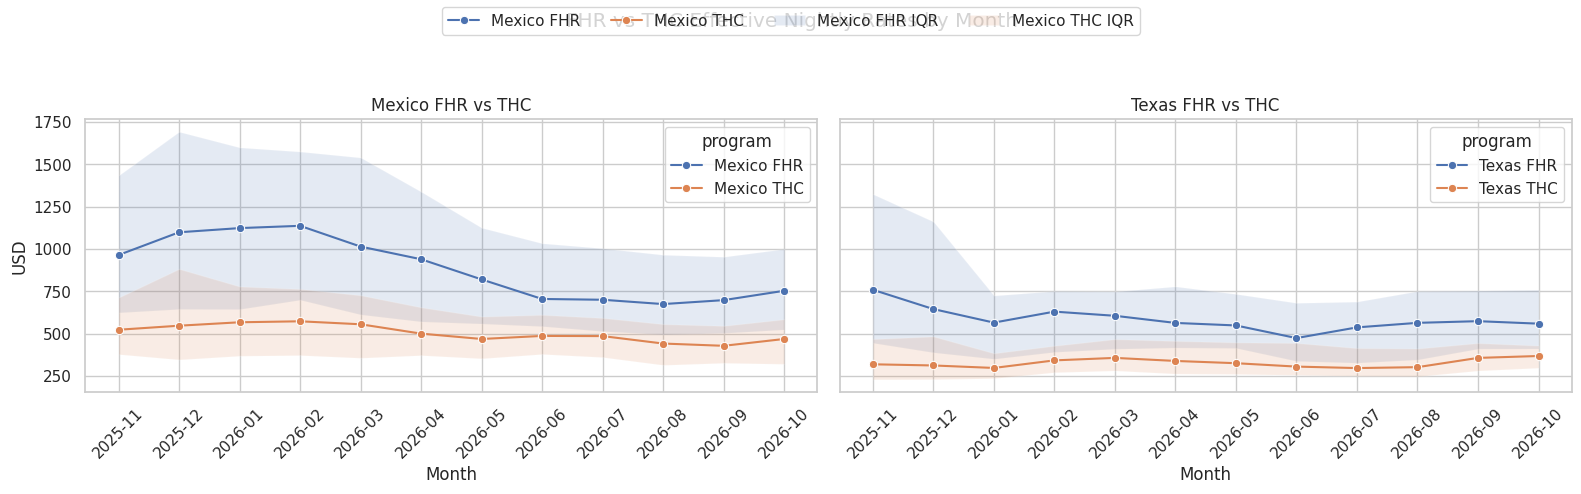

In [199]:
# Plot Mexico vs Texas monthly medians (FHR vs THC)
import seaborn as sns
import matplotlib.pyplot as plt

if pd:
    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    # Mexico subplot
    mexico_combined = pd.concat(
        [mexico_monthly_fhr, mexico_monthly_thc], ignore_index=True
    ) if 'mexico_monthly_thc' in globals() else mexico_monthly_fhr
    if not mexico_combined.empty:
        sns.lineplot(
            data=mexico_combined,
            x='month',
            y='median_rate',
            hue='program',
            marker='o',
            ax=axes[0],
        )
        for program, subset in mexico_combined.groupby('program'):
            axes[0].fill_between(
                subset['month'], subset['p25'], subset['p75'], alpha=0.15, label=f'{program} IQR'
            )
        axes[0].set_title('Mexico FHR vs THC')
        axes[0].set_xlabel('Month')
        axes[0].set_ylabel('USD')
        axes[0].tick_params(axis='x', rotation=45)
    else:
        axes[0].axis('off')
        axes[0].set_title('No Mexico data')

    # Texas subplot
    texas_combined = pd.concat(
        [texas_monthly_fhr, texas_monthly_thc], ignore_index=True
    ) if 'texas_monthly_thc' in globals() else texas_monthly_fhr
    if not texas_combined.empty:
        sns.lineplot(
            data=texas_combined,
            x='month',
            y='median_rate',
            hue='program',
            marker='o',
            ax=axes[1],
        )
        for program, subset in texas_combined.groupby('program'):
            axes[1].fill_between(
                subset['month'], subset['p25'], subset['p75'], alpha=0.15, label=f'{program} IQR'
            )
        axes[1].set_title('Texas FHR vs THC')
        axes[1].set_xlabel('Month')
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].axis('off')
        axes[1].setTitle('No Texas data')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)
    fig.suptitle('FHR vs THC Effective Nightly Rates by Month')
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
else:
    print('Install pandas/seaborn/matplotlib to plot monthly charts')


## Destination-Level Anchors


In [200]:
if pd:
    dest_stats = (
        fhr_df.groupby('destination_name').agg(
            sample_size=('effective_rate', 'count'),
            median_rate=('effective_rate', 'median'),
            p25=('effective_rate', lambda s: s.quantile(0.25)),
            p75=('effective_rate', lambda s: s.quantile(0.75)),
        )
        .reset_index()
        .sort_values('median_rate')
    )
    display(dest_stats)
else:
    None


,destination_name,sample_size,median_rate,p25,p75
7,Puebla,100,235.670,199.0000,289.8325
2,Guerrero,279,484.170,394.7600,698.1700
1,Guanajuato,319,551.670,444.6700,762.5000
9,Yucatán,500,660.165,312.3300,1350.0000
5,Mexico City,576,789.000,601.7525,1060.0000
4,Mexico,35008,816.670,549.0000,1250.6700
8,Quintana Roo,5756,1013.750,715.6500,1415.0000
0,Baja California Sur,968,1422.165,922.6675,2010.0000
3,Jalisco,312,1566.670,1500.0000,1720.8350
6,Nayarit,1922,1658.330,1300.0000,2253.3300


## Benefit & Promo Coverage (FHR)


In [201]:
if pd:
    benefit_cols = ['is_breakfast_included', 'is_food_beverage_credit', 'is_free_cancellation', 'is_parking_included', 'is_shuttle_included']
    stats = []
    total = len(fhr_df)
    for col in benefit_cols:
        count = int(fhr_df[col].sum())
        stats.append({'signal': col, 'count': count, 'share': round(count / total, 3)})
    special_count = int(((fhr_df['special_offer_json'].notna()) & (fhr_df['special_offer_json'] != 'null')).sum())
    supplier_count = int(((fhr_df['supplier_rate_promotion_json'].notna()) & (fhr_df['supplier_rate_promotion_json'] != 'null')).sum())
    stats.append({'signal': 'special_offer_records', 'count': special_count, 'share': round(special_count / total, 3)})
    stats.append({'signal': 'supplier_promo_records', 'count': supplier_count, 'share': round(supplier_count / total, 3)})
    coverage_df = pd.DataFrame(stats)
    display(coverage_df)
else:
    None


,signal,count,share
0,is_breakfast_included,6720,0.147
1,is_food_beverage_credit,0,0.000
2,is_free_cancellation,35239,0.770
3,is_parking_included,35922,0.785
4,is_shuttle_included,0,0.000
5,special_offer_records,21787,0.476
6,supplier_promo_records,9054,0.198


### Interpreting Benefit Flags
- Every FHR booking includes breakfast for two and guaranteed 4pm checkout, but the Amex feed only flips `is_breakfast_included` when the JSON explicitly repeats that language. In other words, a `False` flag usually means "not stated" rather than "not included", so we treat it as a data quality signal instead of removing breakfast value from the score.
- THC stays do **not** automatically include breakfast, so the same flag becomes a true differentiator once we load THC rows.
- Supplier promos and special offers are explicit (non-null JSON), so their shares represent real stackable deals we can lean on for value scoring.


## Property Credit Extraction


In [202]:
CREDIT_PATTERN = re.compile(r'(?:\$|USD\s*)(\d{2,5})')

def extract_credit_amount(payload: str | None) -> float:
    if not payload or payload in {'null', '', '[]', '{}'}:
        return 0.0
    try:
        data = json.loads(payload)
    except json.JSONDecodeError:
        data = payload
    text_chunks: list[str] = []

    def walk(node: Any) -> None:
        if isinstance(node, dict):
            for value in node.values():
                walk(value)
        elif isinstance(node, list):
            for value in node:
                walk(value)
        elif isinstance(node, str):
            text_chunks.append(node)
        else:
            text_chunks.append(str(node))

    walk(data)
    blob = ' '.join(text_chunks)
    matches = [int(m.group(1)) for m in CREDIT_PATTERN.finditer(blob)]
    return float(max(matches)) if matches else 0.0

if pd:
    fhr_df['property_credit_amount'] = fhr_df['special_offer_json'].apply(extract_credit_amount)
    credit_summary = (
        fhr_df.groupby('property_credit_amount')
        .size()
        .reset_index(name='count')
        .sort_values('property_credit_amount')
    )
    credit_summary['share'] = (credit_summary['count'] / credit_summary['count'].sum()).round(3)
    display(credit_summary.head(20))
else:
    None


,property_credit_amount,count,share
0,0.0,23953,0.524
1,100.0,17080,0.373
2,150.0,593,0.013
3,200.0,791,0.017
4,250.0,861,0.019
5,400.0,621,0.014
6,500.0,1239,0.027
7,1000.0,510,0.011
8,1800.0,92,0.002


### Property Credit Notes
- Most FHR descriptions omit the dollar figure, so ~50% of rows show `$0` even though the on-property benefit is still at least $100.
- Roughly a third of entries explicitly state the standard $100 credit, while the remaining 15% surface high-value perks ($150–$1,800).
- We can treat the parsed amount as a *bonus* on top of the guaranteed $100 when scoring value: assume $100 minimum, then add whatever the JSON reveals for above-market offers.


## Supplier Promo Depth by Destination


In [203]:
if pd:
    fhr_df['has_supplier_promo'] = fhr_df['supplier_rate_promotion_json'].apply(lambda x: bool(x) and x != 'null')
    supplier_share = fhr_df.groupby('destination_name')['has_supplier_promo'].mean().reset_index().sort_values('has_supplier_promo', ascending=False)
    display(supplier_share)
else:
    None


,destination_name,has_supplier_promo
8,Quintana Roo,0.313760
2,Guerrero,0.301075
5,Mexico City,0.222222
1,Guanajuato,0.210031
4,Mexico,0.188014
6,Nayarit,0.137357
0,Baja California Sur,0.088843
9,Yucatán,0.074000
3,Jalisco,0.000000
7,Puebla,0.000000


## Draft Brand Tiers


In [204]:
BRAND_TIERS = {
    'Tier 1 - Ultra Luxury': {
        'Four Seasons', 'Mandarin Oriental', 'Aman', 'Rosewood', 'One&Only', 'Bulgari',
        'Cheval Blanc', 'Belmond', 'Six Senses', 'Capella', 'Auberge Resorts', 'Raffles'
    },
    'Tier 2 - Luxury': {
        'St Regis', 'Ritz-Carlton', 'Park Hyatt', 'Waldorf Astoria', 'Conrad', 'JW Marriott',
        'Fairmont', 'Edition', 'Thompson Hotels', 'Andaz', 'Luxury Collection', 'Banyan Tree',
        'Grand Velas', 'Kempinski Hotels & Resorts', 'SLS', 'Baccarat', 'SO/', 'Xcaret Hotels'
    },
    'Tier 3 - Upscale': {
        'Hyatt Centric', 'Curio Collection', 'Autograph Collection', 'Marriott Bonvoy',
        'Kimpton', 'Westin', 'Le Méridien', 'Hilton', 'InterContinental'
    },
}

def map_brand_tier(name: str | None) -> str:
    if not name:
        return 'Unspecified'
    for tier, brands in BRAND_TIERS.items():
        if name in brands:
            return tier
    return 'Independent / Other'

if pd:
    fhr_df['brand_tier'] = fhr_df['brand_name'].apply(map_brand_tier)
    tier_summary = (
        fhr_df['brand_tier'].value_counts(normalize=True)
        .round(3)
        .reset_index()
        .rename(columns={'index': 'brand_tier', 'brand_tier': 'share'})
    )
    display(tier_summary)
    top_brands = (
        fhr_df['brand_name']
        .value_counts()
        .reset_index()
        .rename(columns={'index': 'brand', 'brand_name': 'count'})
        .head(20)
    )
    display(top_brands)
else:
    None


,share,proportion
0,Independent / Other,0.502
1,Tier 2 - Luxury,0.381
2,Tier 1 - Ultra Luxury,0.117


,count,count
0,Independent,7881
1,Four Seasons,3915
2,Banyan Tree,3774
3,Rosewood Hotels,3282
4,none,2652
5,St Regis,2523
6,Conrad,1695
7,One&Only Resorts,1659
8,Waldorf Astoria,1628
9,Ritz-Carlton,1487


## Review Quality Signals


In [205]:
if pd:
    review_df = fhr_df[['hotel_name', 'brand_name', 'user_rating', 'user_rating_count']].dropna(subset=['user_rating'])
    review_df = review_df[review_df['user_rating_count'] > 0]
    review_df['weighted_rating'] = review_df['user_rating'] * (review_df['user_rating_count'].clip(upper=500) / 500)
    display(review_df.sort_values('weighted_rating', ascending=False).head(15))
else:
    None


,hotel_name,brand_name,user_rating,user_rating_count,weighted_rating
9136,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
10551,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
9638,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
13908,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
10036,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
10035,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
11388,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
11389,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
9637,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0
12504,Grand Velas Los Cabos - All Inclusive,Grupo Velas,5.0,2173.0,5.0


## Candidate Feature List (FHR)
- `effective_rate` relative to destination-month medians (seasonality-aware pricing delta).
- `property_credit_amount` parsed from offer JSON plus per-night normalization.
- `has_supplier_promo` share by destination and run (captures stacked promos).
- Benefit flags (breakfast, F&B credit, parking, shuttle) to highlight above-baseline perks.
- `brand_tier` and raw brand counts (reputation weighting).
- `weighted_rating` (rating * normalized review volume).

Next steps: add THC mirrors, parse promo titles (hotel_promotions), and prototype a weighted score where every component is explainable (rate delta, credit dollars, brand tier boost, review quality).


In [ ]:
%%sql


Exception: Variable Name is not chosen